## 0. Set up preparation

### Auto-Reload

In [1]:
%load_ext autoreload
%autoreload 2
# 파이썬 코드를 실행하기 전에 항상 모든 모듈을 Reload

### Add a module path

In [2]:
import os
import sys

In [ ]:
# This command returns the absolute path of the folder where Jupyter is running. If you want to use a different path instead of the Jupyter folder, please modify it.
jupyter_run_dir = os.getcwd()
print(f'The current active folder is "{jupyter_run_dir}".\n')

# module path
module_dir = jupyter_run_dir + '/Image-to-NPZ_dataset-with-DA'

sys.path.append(module_dir)
print(sys.path[-1])

The current active folder is "/mnt/4d055040/lab".

/mnt/4d055040/lab/Splitting-data


### Maintain the experiment under the same conditions.

In [4]:
import random
import numpy as np

def seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed()

## 1. DA

### Loading an npz dataset.
> Loading the npz file saved in `1-make_a_dataset.ipynb` or `1-make_a_dataset_for_k-fold.ipynb`.

In [5]:
from utils.utils import load_npz_dataset

In [14]:
npz_path = '/mnt/7977asdasf/npz/train0.6val0.2test0.2.npz'
class_names, x_train, x_valid, x_test, y_train, y_valid, y_test = load_npz_dataset(npz_path)
class_names

array(['TNBC_baseline', 'Normal'], dtype='<U13')

### Calculating the number of datasets after performing data augmentation and combining them.

In [21]:
print(f'All count : {y_train.shape}')

data_count = [len(np.where(np.array(y_train) == i)[0]) for i in range(len(class_names))]
ori0, ori1 = data_count

print('=========================================')
for i, j in zip([0,1,1,2], [1,3,4,5]):
    one, two = ori0*(i+1), ori1*(j+1)
    print(f'{class_names[0]} x{i} & {class_names[1]} x{j} : {one}, {two} -> sum : {one + two}')
print()

All count : (531,)
TNBC_baseline x0 & Normal x1 : 365, 332 -> sum : 697
TNBC_baseline x1 & Normal x3 : 730, 664 -> sum : 1394
TNBC_baseline x1 & Normal x4 : 730, 830 -> sum : 1560
TNBC_baseline x2 & Normal x5 : 1095, 996 -> sum : 2091



### Performing data augmentation for brightness adjustment.

In [24]:
from utils.data_augmentation import bright_DA_run

##### Option 1. single-processing (Recommendation)

Image shape:  (800, 400, 3)


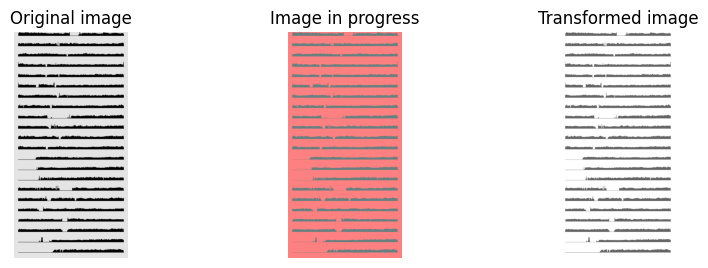

After shape : ((697, 800, 400, 3), (697,))
save...



In [31]:
bright_DA_run([npz_path], [0, 1], [0, 1], save=False)

##### Option 2. Speeding up data transformation using multi-processing -> Overhead

In [ ]:
from concurrent.futures import ProcessPoolExecutor
import multiprocessing

In [ ]:
DA_dict['cnt_of_DA_reuslt'] = [np.zeros(len(DA_dict['cnt_per_class_for_DA']), dtype=np.int32).tolist() for _ in npz_file_path]
DA_dict

{'class_for_DA': [0, 1],
 'cnt_per_class_for_DA': [[0, 1], [1, 3]],
 'cnt_of_DA_reuslt': [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]}

In [ ]:
multi_npz_file_path = []
for cnt_per_class_for_DA in DA_dict['cnt_per_class_for_DA']:
    multi_npz_file_path.extend([[npz_file, cnt_per_class_for_DA] for npz_file in [npz_path]])

In [ ]:
# num_cores = multiprocessing.cpu_count() # 64 core
num_cores = len(npz_file_path)
num_cores

5

In [ ]:
splited_data = np.array_split(multi_npz_file_path, num_cores)
splited_data = [_ for _ in splited_data if len(_) != 0]
splited_data

Image shape:  (800, 400, 3)


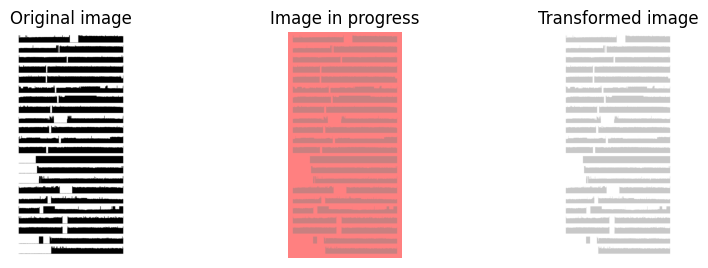

After shape : ((1292, 800, 400, 3), (1292,))
After shape : ((1294, 800, 400, 3), (1294,))
0:02:48.150451


In [ ]:
# cnt_per_class_for_DA : [0,1] & 5-fold (used 2 files) -> real run time : 5m ??s but,,,,, printed run time is 2m 48s
def pass_DA(data):
    return bright_DA_run(npz_file_path=[data[0][0]], class_aug=data[0][1], class_label=DA_dict['class_for_DA'], save=False, return_new_label_shape=True)

start = time.time()
pool = ProcessPoolExecutor(max_workers=num_cores)
results = list(pool.map(pass_DA, splited_data))
end = time.time()

sec = (end - start)
print(datetime.timedelta(seconds=sec))

In [ ]:
for r, data in zip(results, splited_data):
    now_fold = int(data[0][0].split('/')[-1].split('-fold')[0])-1
    now_aug = int(DA_dict['cnt_per_class_for_DA'].index(data[0][1]))
    DA_dict['cnt_of_DA_reuslt'][now_fold][now_aug] = r

for i, npz_file in enumerate([npz_path]):
    print(npz_file.split('/')[-1])
    for j, cnt_per_class_for_DA in enumerate(DA_dict['cnt_per_class_for_DA']):
        class_DA_str = [f'{class_names[class_num]} x{DA_num}' for class_num, DA_num in enumerate(cnt_per_class_for_DA)]
        print(f"{' & '.join(class_DA_str)} -> Total : {DA_dict['cnt_of_DA_reuslt'][i][j]}")
    print()

1-fold-test0.2-example.npz
Normal x0 & Pancreatic x1 -> Total : (646,)
Normal x1 & Pancreatic x3 -> Total : (1292,)

2-fold-test0.2-example.npz
Normal x0 & Pancreatic x1 -> Total : (647,)
Normal x1 & Pancreatic x3 -> Total : (1294,)

